### Importing necessary libraries

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision import datasets
from torchvision import transforms, models

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [83]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Download datasets and Transform images

Get the "CIFAR-10" image data from the source.

In [84]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = datasets.CIFAR10("./data", download = True, train = True, transform = transform)
testset = datasets.CIFAR10("./data", download = True, train = False, transform = transform)

Files already downloaded and verified
Files already downloaded and verified


I randomly choose two subset with size = 100 for train and two subset with size = 10 fir test.

In [85]:
subset_size = 100
train_indexes = list(range(len(trainset)))
np.random.shuffle(train_indexes)
train_sample_1 = SubsetRandomSampler(train_indexes[:subset_size])
np.random.shuffle(train_indexes)
train_sample_2 = SubsetRandomSampler(train_indexes[:subset_size])

test_indexes = list(range(len(testset)))
np.random.shuffle(test_indexes)
test_sample_1 = SubsetRandomSampler(test_indexes[:10])
np.random.shuffle(test_indexes)
test_sample_2 = SubsetRandomSampler(test_indexes[:10])

trainloader_1 = DataLoader(trainset, sampler = train_sample_1, batch_size = 1)
trainloader_2 = DataLoader(trainset, sampler = train_sample_2, batch_size = 1)

testloader_1 = DataLoader(testset, sampler = test_sample_1, batch_size = 1)
testloader_2 = DataLoader(testset, sampler = test_sample_2, batch_size = 1)

### Visualize a Batch of Training Data

To see some images and their labels from train dataset I use matplotlib.

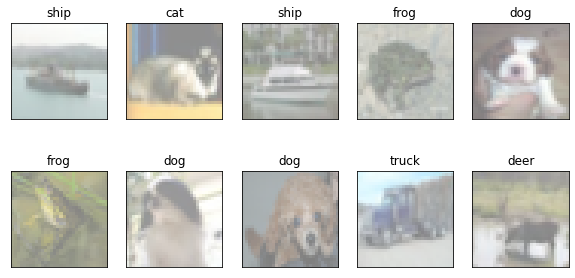

In [86]:
label_names = ["airplane", "automobile", "bird", "cat", "deer",
               "dog", "frog", "horse", "ship", "truck"]
data = iter(trainloader_1)
fig = plt.figure(figsize=(10,5))
for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    image, label = next(data)
    image = image[0].cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    plt.imshow(image)
    ax.set_title(label_names[label.item()])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### Define the train and test methods

This method will train the model. Forward and backward phases are implemented. At the end, train loss are printed for each epoch.

In [87]:
def train(n_epochs, model, optimizer, criterion):
  model.train()
  
  losses = []
  for epoch in range(n_epochs):
    train_loss = 0.0
    for image_1, label_1 in trainloader_1:
        for image_2, label_2 in trainloader_2:
          image_1 = image_1.to(device)
          image_2 = image_2.to(device)
          input = combineImages(image_1, image_2)
          input = input.to(device)
          output_1, output_2 = model(input)
          output_1 = output_1.to(device)
          output_2 = output_2.to(device)
          loss_1 = criterion(output_1, image_1)
          loss_2 = criterion(output_2, image_2)
          loss = loss_1 + loss_2
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          train_loss += loss.data

    train_loss = train_loss/(len(trainloader_1.sampler)*len(trainloader_2.sampler))
    losses.append(float(train_loss.to(device)))
    print('Epoch {} ---> Training Loss: {:.4f}'.format(epoch + 1, train_loss))


Test the traind model with test subset and report the test loss.

In [88]:
def test(model, criterion):
  model.eval()

  first_images = []
  second_images = []
  inputs = []
  first_outputs = []
  second_outputs = []
  test_loss = 0.0
  for image_1, label_1 in testloader_1:
      for image_2, label_2 in trainloader_2:
        image_1 = image_1.to(device)
        image_2 = image_2.to(device)
        first_images.append(image_1)
        second_images.append(image_2)
        input = combineImages(image_1, image_2)
        input = input.to(device)
        inputs.append(input)
        output_1, output_2 = model(input)
        output_1 = output_1.to(device)
        output_2 = output_2.to(device)
        first_outputs.append(output_1)
        second_outputs.append(output_2)
        loss_1 = criterion(output_1, image_1)
        loss_2 = criterion(output_2, image_2)
        test_loss += (loss_1 + loss_2).data
      
  test_loss = test_loss/(len(testloader_1.sampler)*len(testloader_2.sampler))
  print('Test Loss: {:.6f}\n'.format(test_loss))
  return [first_images, second_images, inputs, first_outputs, second_outputs]

### Create input for model

In [89]:
def combineImages(image_1, image_2):
  input = [((image_1[0].cpu().numpy() + image_2[0].cpu().numpy())/2).tolist()]
  return torch.FloatTensor(input)

## AutoEncoder Model
It has one encoder and two decoder. in encoder there are 4 convolution layers with Relu as activation function. 
and in decoders there are four transpose convolution layer and Relu.

In [112]:
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),      
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),      
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),            
            nn.ReLU(),
        )

        self.decoder_1 = torch.nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, stride=1, padding=1), 
            nn.Sigmoid(),
        )
        self.decoder_2 = torch.nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1),  
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size=3, stride=1, padding=1), 
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded_1 = self.decoder_1(encoded)
        decoded_2 = self.decoder_2(encoded)
        return decoded_1, decoded_2

Train the model with 10 epochs and using Adam optimizer with learning rate = 0.001 and MSE as loss function.

In [117]:
n_epochs = 7
model = AutoEncoder().to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.MSELoss()
train(n_epochs, model, optimizer, criterion)

Epoch 1 ---> Training Loss: 0.0497
Epoch 2 ---> Training Loss: 0.0465
Epoch 3 ---> Training Loss: 0.0472
Epoch 4 ---> Training Loss: 0.0473
Epoch 5 ---> Training Loss: 0.0474
Epoch 6 ---> Training Loss: 0.0476
Epoch 7 ---> Training Loss: 0.0461


In [118]:
history = test(model, criterion)

Test Loss: 0.898016



Total test loss for testing 100 pairs of images became : 

Now we can plot the first and second images and also the combination as input and two outputs of model

In [119]:
def convertImage(image):
    image = image[0].cpu().clone().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    return image

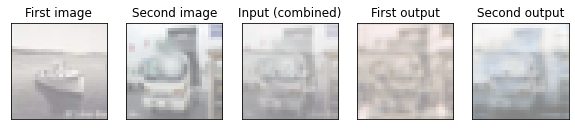

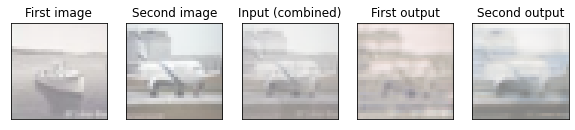

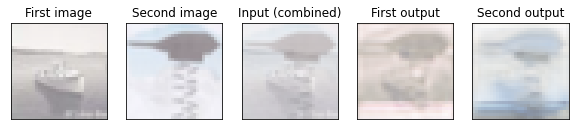

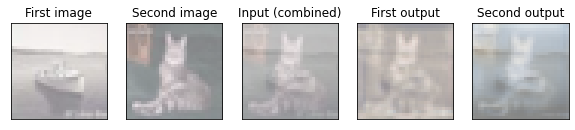

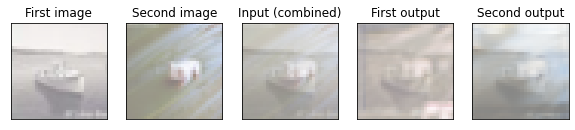

In [120]:
for i in range(5):
    fig = plt.figure(figsize=(10,5))
    image_1 = convertImage(history[0][i])
    image_2 = convertImage(history[1][i])
    input = convertImage(history[2][i])
    output_1 = convertImage(history[3][i])
    output_2 = convertImage(history[4][i])
    
    j=1
    ax = plt.subplot(1, 5, j)
    j+=1
    plt.imshow(image_1)
    ax.set_title('First image')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(1, 5, j)
    j+=1
    plt.imshow(image_2)
    ax.set_title('Second image')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(1, 5, j)
    j+=1
    plt.imshow(input)
    ax.set_title('Input (combined)')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(1, 5, j)
    j+=1
    plt.imshow(output_1)
    ax.set_title('First output')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(1, 5, j)
    plt.imshow(output_2)
    ax.set_title('Second output')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.show()
